salt and peper applied comes in first part, only gaussian is in second part

CNN denoiser with salt and pepper


In [ ]:
import os
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


# Define paths
train_path = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/train'
val_path = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/val'
test_path = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/test'
output_size = (256, 256)

# Load images and preprocess
def load_and_preprocess_images(dataset_paths, output_size, form= '*.jpg'):
    images = []
    for dataset_path in dataset_paths:
        image_paths = glob.glob(os.path.join(dataset_path, form))
        for img_path in image_paths:
            img = cv2.imread(img_path)
            img = cv2.resize(img, output_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

train_images = load_and_preprocess_images([train_path], output_size)
val_images = load_and_preprocess_images([val_path], output_size)
test_images = load_and_preprocess_images([test_path], output_size)

# Concatenate train, validation, and test images
all_images = np.concatenate((train_images, val_images, test_images), axis=0)
print(f"All images shape: {all_images.shape}")

import numpy as np

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy = np.copy(image)
    # Salt noise
    num_salt = np.ceil(salt_prob * image.size)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 1

    # Pepper noise
    num_pepper = np.ceil(pepper_prob * image.size)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 0
    return noisy

def add_noise(images, gaussian_range=(0.1, 0.9), salt_prob_range=(0.008, 0.04), pepper_prob_range=(0.008, 0.04)):
    noisy_images = []
    for img in images:
        # Add first round of salt-and-pepper noise
        #noisy_img = add_salt_and_pepper_noise(img, salt_prob, pepper_prob)

        # Add Gaussian noise
        #noise_factor = np.random.uniform(*gaussian_range)
        #noisy_img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
        #noisy_img = np.clip(noisy_img, 0., 1.)

        # Add  round of salt-and-pepper noise
        salt_prob = np.random.uniform(*salt_prob_range)
        pepper_prob = np.random.uniform(*pepper_prob_range)
        noisy_img = add_salt_and_pepper_noise(img, salt_prob, pepper_prob)

        noisy_images.append(noisy_img)
    return np.array(noisy_images)

# Apply the noise
noisy_all_images = add_noise(all_images)
print(f"Noisy images shape: {noisy_all_images.shape}")

#noisy_all_images = add_noise(all_images)
#print(f"Noisy images shape: {noisy_all_images.shape}")

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(noisy_all_images, all_images, test_size=0.1, random_state=42)


All images shape: (500, 256, 256, 3)
Noisy images shape: (500, 256, 256, 3)


In [ ]:
[0.001, 0.01, 0.01]
print(np.random.uniform(*(0.01, 0.05)))

0.0326146358271492


2


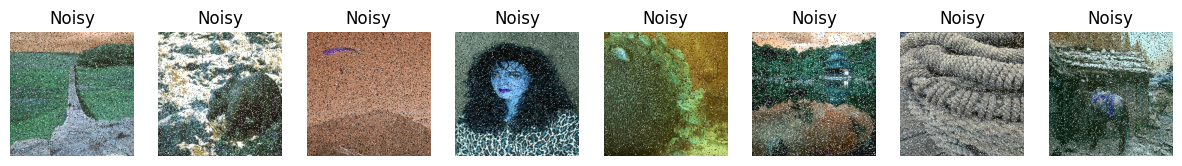

1


In [ ]:
def visualize_noisy_images(original_images, noisy_images, num_images=8):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Original image
        #plt.subplot(2, num_images, i + 1)
        #plt.imshow(original_images[i])
        #plt.title('Original')
        #plt.axis('off')

        # Noisy image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(noisy_images[i])
        plt.title('Noisy')
        plt.axis('off')
    plt.show()

print(2)
# Display the images
visualize_noisy_images(all_images, noisy_all_images)
print(1)

In [ ]:
def dncnn(depth, filters=64, image_channels=3, use_bnorm=True):
    layer_count = 0
    input = Input(shape=(None, None, image_channels), name='input' + str(layer_count))
    layer_count += 1
    x = Conv2D(filters, (3, 3), padding='same', name='conv' + str(layer_count))(input)
    layer_count += 1
    x = Activation('relu', name='relu' + str(layer_count))(x)
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters, (3, 3), padding='same', use_bias=False, name='conv' + str(layer_count))(x)
        if use_bnorm:
            x = BatchNormalization(axis=3, epsilon=1e-3, name='bn' + str(layer_count))(x)
        x = Activation('relu', name='relu' + str(layer_count))(x)
    layer_count += 1
    x = Conv2D(image_channels, (3, 3), padding='same', use_bias=False, name='conv' + str(layer_count))(x)
    layer_count += 1
    x = Add(name='add' + str(layer_count))([input, x])
    model = Model(inputs=input, outputs=x)
    return model

# Create DnCNN model
dncnn_model = dncnn(depth=17)
opt = Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.0, amsgrad=False)
dncnn_model.compile(optimizer=opt, loss='mean_squared_error')


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('dncnn_general_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train DnCNN model
dncnn_model.fit(x_train, y_train,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(x_val, y_val),
                callbacks=[early_stopping, checkpoint])

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 616ms/step - loss: 0.5972 - val_loss: 0.0421
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 430ms/step - loss: 0.0446 - val_loss: 0.0417
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step - loss: 0.0416 - val_loss: 0.0416
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 424ms/step - loss: 0.0407 - val_loss: 0.0417
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 423ms/step - loss: 0.0376 - val_loss: 0.0418
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 430ms/step - loss: 0.0302 - val_loss: 0.0404
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 430ms/step - loss: 0.0225 - val_loss: 0.0383
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step - loss: 0.0181 - val_loss: 0.0349
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 430ms/step - loss: 0.0153 - val_loss: 0.0313
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step - loss: 0.0135 - val_loss: 0.0296
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - loss: 0.0122 - val_loss: 0.0253
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


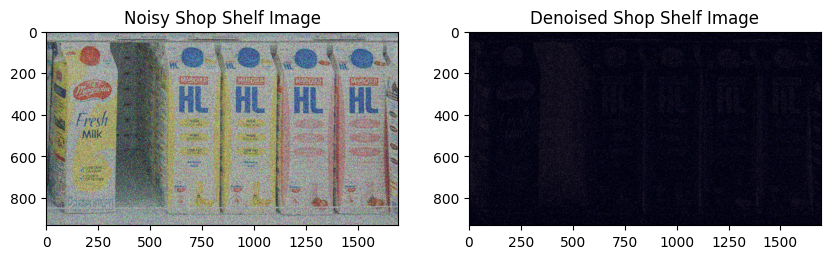

In [ ]:
dncnn_model.load_weights('dncnn_general_model.keras')
def denoise_image(img, model):
    noisy_image = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    denoised_image = model.predict(noisy_image)
    return denoised_image.reshape(img.shape)

shop_shelf_image_path = '/kaggle/input/shelfs/scenes/scene10.png'
shop_shelf_image = cv2.imread(shop_shelf_image_path)
shop_shelf_image = cv2.cvtColor(shop_shelf_image, cv2.COLOR_BGR2RGB)
#shop_shelf_image = cv2.resize(shop_shelf_image, output_size)
shop_shelf_image = shop_shelf_image / 255.0
denoised_shop_shelf_image = denoise_image(shop_shelf_image, dncnn_model)

# Display the original and denoised shop shelf images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Noisy Shop Shelf Image')
plt.imshow(shop_shelf_image)
plt.subplot(1, 2, 2)
plt.title('Denoised Shop Shelf Image')
plt.imshow(denoised_shop_shelf_image)
plt.show()


only gaussian CNN denoiser


In [ ]:
import os
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


# Define paths
train_path = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/train'
val_path = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/val'
test_path = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/test'
output_size = (256, 256)

# Load images and preprocess
def load_and_preprocess_images(dataset_paths, output_size, form= '*.jpg'):
    images = []
    for dataset_path in dataset_paths:
        image_paths = glob.glob(os.path.join(dataset_path, form))
        for img_path in image_paths:
            img = cv2.imread(img_path)
            img = cv2.resize(img, output_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

train_images = load_and_preprocess_images([train_path], output_size)
val_images = load_and_preprocess_images([val_path], output_size)
test_images = load_and_preprocess_images([test_path], output_size)

# Concatenate train, validation, and test images
all_images = np.concatenate((train_images, val_images, test_images), axis=0)
print(f"All images shape: {all_images.shape}")

def add_noise(images, a= 0.1, b=0.9):
    noisy_images = []
    for img in images:
        noise_factor = np.random.uniform(a, b)
        noisy_img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
        noisy_img = np.clip(noisy_img, 0., 1.)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

noisy_all_images = add_noise(all_images)
print(f"Noisy images shape: {noisy_all_images.shape}")

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(noisy_all_images, all_images, test_size=0.1, random_state=42)


2024-05-16 17:00:39.873543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 17:00:39.873688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 17:00:40.051278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All images shape: (500, 256, 256, 3)
Noisy images shape: (500, 256, 256, 3)


In [ ]:
def dncnn(depth, filters=64, image_channels=3, use_bnorm=True):
    layer_count = 0
    input = Input(shape=(None, None, image_channels), name='input' + str(layer_count))
    layer_count += 1
    x = Conv2D(filters, (3, 3), padding='same', name='conv' + str(layer_count))(input)
    layer_count += 1
    x = Activation('relu', name='relu' + str(layer_count))(x)
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters, (3, 3), padding='same', use_bias=False, name='conv' + str(layer_count))(x)
        if use_bnorm:
            x = BatchNormalization(axis=3, epsilon=1e-3, name='bn' + str(layer_count))(x)
        x = Activation('relu', name='relu' + str(layer_count))(x)
    layer_count += 1
    x = Conv2D(image_channels, (3, 3), padding='same', use_bias=False, name='conv' + str(layer_count))(x)
    layer_count += 1
    x = Add(name='add' + str(layer_count))([input, x])
    model = Model(inputs=input, outputs=x)
    return model

# Create DnCNN model
dncnn_model = dncnn(depth=17)
opt = Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.0, amsgrad=False)
dncnn_model.compile(optimizer=opt, loss='mean_squared_error')


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('dncnn_general_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train DnCNN model
dncnn_model.fit(x_train, y_train,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(x_val, y_val),
                callbacks=[early_stopping, checkpoint])

Epoch 1/50


2024-05-16 17:01:34.673347: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-16 17:01:35.311953: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.638691431s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-16 17:01:37.771210: E external/

29/29 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.4712 - val_loss: 0.1186
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 850ms/step - loss: 0.1120 - val_loss: 0.1187
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 864ms/step - loss: 0.1117 - val_loss: 0.1185
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 875ms/step - loss: 0.1104 - val_loss: 0.1182
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 870ms/step - loss: 0.0994 - val_loss: 0.1182
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 882ms/step - loss: 0.0941 - val_loss: 0.1171
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 890ms/step - loss: 0.0833 - val_loss: 0.1150
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 895ms/step - loss: 0.0748 - val_loss: 0.1117
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 897ms/step - loss: 0.0654 - val_loss: 0.1068
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 898ms/step - loss: 0.0563 - val_loss: 0.0964
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 898ms/step - loss: 0.0506 - val_loss: 0.0746
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 898ms/step -

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


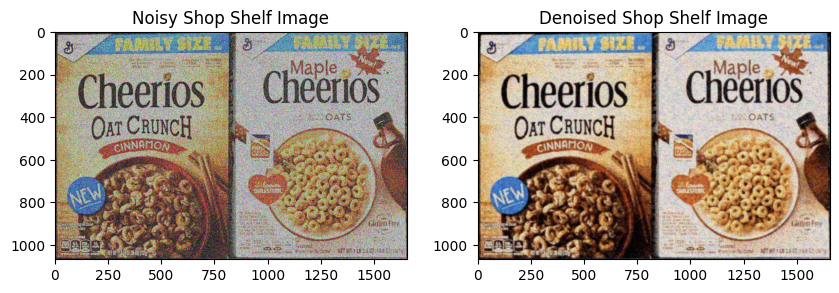

In [ ]:
dncnn_model.load_weights('dncnn_general_model.keras')
def denoise_image(img, model):
    noisy_image = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    denoised_image = model.predict(noisy_image)
    return denoised_image.reshape(img.shape)

shop_shelf_image_path = '/kaggle/input/shelfs/scenes/scene1.png'
shop_shelf_image = cv2.imread(shop_shelf_image_path)
shop_shelf_image = cv2.cvtColor(shop_shelf_image, cv2.COLOR_BGR2RGB)
#shop_shelf_image = cv2.resize(shop_shelf_image, output_size)
shop_shelf_image = shop_shelf_image / 255.0
denoised_shop_shelf_image = denoise_image(shop_shelf_image, dncnn_model)

# Display the original and denoised shop shelf images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Noisy Shop Shelf Image')
plt.imshow(shop_shelf_image)
plt.subplot(1, 2, 2)
plt.title('Denoised Shop Shelf Image')
plt.imshow(denoised_shop_shelf_image)
plt.show()


In [ ]:
output_file_path = "/kaggle/working/out.jpg"
denoised_shop_shelf_image = np.clip(denoised_shop_shelf_image * 255, 0, 255).astype(np.uint8)
cv2.imwrite(output_file_path, cv2.cvtColor(denoised_shop_shelf_image, cv2.COLOR_RGB2BGR))


True

In [ ]:
#dncnn_model.load_weights('dncnn_general_model.keras')
shop_shelf_image_path = '/kaggle/input/shelfs/scenes/scene'

for i in range(1,13):
    k = shop_shelf_image_path + str(i) + '.png'
    shop_shelf_image = cv2.imread(k)
    shop_shelf_image = cv2.cvtColor(shop_shelf_image, cv2.COLOR_BGR2RGB)
    shop_shelf_image = shop_shelf_image / 255.0
    denoised_shop_shelf_image = denoise_image(shop_shelf_image, dncnn_model)
    output_file_path = "/kaggle/working/Dscene{}.jpg".format(i)
    denoised_shop_shelf_image = np.clip(denoised_shop_shelf_image * 255, 0, 255).astype(np.uint8)
    cv2.imwrite(output_file_path, cv2.cvtColor(denoised_shop_shelf_image, cv2.COLOR_RGB2BGR))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [ ]:
specific_dataset_path = '/kaggle/input/shelfs/models'

dncnn_model.load_weights('dncnn_general_model.keras')

# Fine-tune on specific dataset
specific_images = load_and_preprocess_images([specific_dataset_path], output_size, form='*.png')
print(specific_images.shape)
noisy_specific_images = add_noise(specific_images)

x_train_specific, x_val_specific, y_train_specific, y_val_specific = train_test_split(noisy_specific_images, specific_images, test_size=0.1, random_state=42)

print(f"x_train_specific shape: {x_train_specific.shape}, y_train_specific shape: {y_train_specific.shape}")
print(f"x_val_specific shape: {x_val_specific.shape}, y_val_specific shape: {y_val_specific.shape}")


# Fine-tune the model on the specific dataset


(27, 256, 256, 3)
x_train_specific shape: (24, 256, 256, 3), y_train_specific shape: (24, 256, 256, 3)
x_val_specific shape: (3, 256, 256, 3), y_val_specific shape: (3, 256, 256, 3)


In [ ]:
fine_tuning_checkpoint = ModelCheckpoint('dncnn_finetuned_model.keras', monitor='val_loss', save_best_only=True)

dncnn_model.fit(x_train_specific, y_train_specific,
                epochs=3,
                batch_size=8,
                shuffle=True,
                validation_data=(x_val_specific, y_val_specific),
                callbacks=[early_stopping, fine_tuning_checkpoint])


Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.0512 - val_loss: 0.0657
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - loss: 0.0420 - val_loss: 0.1115
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step - loss: 0.0360 - val_loss: 0.1198


In [ ]:
output_file_path = "/kaggle/working/out.jpg"
denoised_shop_shelf_image = np.clip(denoised_shop_shelf_image * 255, 0, 255).astype(np.uint8)
cv2.imwrite(output_file_path, cv2.cvtColor(denoised_shop_shelf_image, cv2.COLOR_RGB2BGR))


True

In [ ]:
# Load and preprocess BSDS500 dataset
train_images = load_and_preprocess_images([train_path, val_path, test_path], output_size)

transferL_images = add_noise()

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(noisy_train_images, train_images, test_size=0.1, random_state=42)



In [ ]:


autoencoder.fit(product_images_noisy, product_images_resized,
                epochs=10,
                batch_size=16,
                shuffle=True,
                validation_split=0.2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


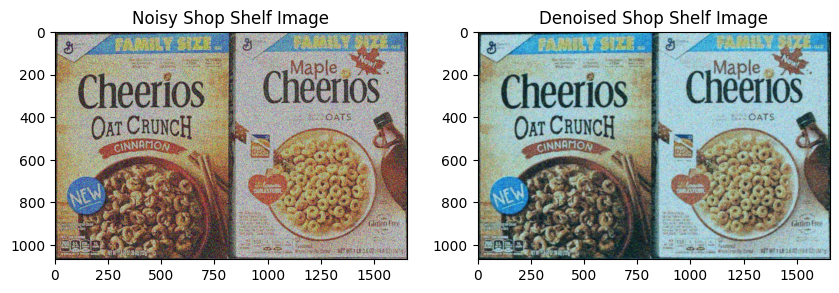

In [ ]:
def denoise_image(img, model):
    noisy_image = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    denoised_image = model.predict(noisy_image)
    return denoised_image.reshape(img.shape)

shop_shelf_image_path = '/kaggle/input/shelfs/scenes/scene1.png'
shop_shelf_image = cv2.imread(shop_shelf_image_path)
shop_shelf_image = cv2.cvtColor(shop_shelf_image, cv2.COLOR_BGR2RGB)
#shop_shelf_image = cv2.resize(shop_shelf_image, output_size)
shop_shelf_image = shop_shelf_image / 255.0
denoised_shop_shelf_image = denoise_image(shop_shelf_image, dncnn_model)

# Display the original and denoised shop shelf images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Noisy Shop Shelf Image')
plt.imshow(shop_shelf_image)
plt.subplot(1, 2, 2)
plt.title('Denoised Shop Shelf Image')
plt.imshow(denoised_shop_shelf_image)
plt.show()


In [ ]:
output_file_path = "/kaggle/working/out.jpg"
denoised_shop_shelf_image = np.clip(denoised_shop_shelf_image * 255, 0, 255).astype(np.uint8)
cv2.imwrite(output_file_path, cv2.cvtColor(denoised_shop_shelf_image, cv2.COLOR_RGB2BGR))


True